# Mira regnet

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

import torch

import pyciemss
from pyciemss.PetriNetODE.interfaces import (setup_petri_model, reset_model, intervene_petri_model, intervene,
                                             sample_petri, calibrate_petri, optimize, load_petri_model)
from pyciemss.PetriNetODE.models import MiraRegNetODESystem, LotkaVolterra
import mira
from pyciemss.utils import get_tspan
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.visuals import vega
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


## Plotting utils

In [3]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population')
    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data.squeeze().detach().numpy(), color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

COLORS=['red','blue','green','black','gold', 'magenta', 'purple']

def plot_trajectories(sol, tspan, data=None):
    fig = plt.figure(facecolor='w', figsize=(6, 6))
    ax = fig.add_subplot(111, axisbelow=True) # setup graph
    d_keys = [list(x[1].keys())[0] for x in data] if data else [] # get affected variables
    torch_tspan = torch.as_tensor(tspan) # for use in multi-trajectory graph
    indices = torch.ones_like(tspan).bool()
    
    for i,var in enumerate([s for s in sol if '_sol' in s]): # skip beta, gamma parameters
        
        if len(sol[var]) == 1: # single trajectory, draw line
            ax.plot(tspan, sol[var].squeeze().detach().numpy(), COLORS[i], alpha=0.5, lw=3, label=var[:-4])
        
        else: # fill between multiple trajectories
            I_low = torch.quantile(sol[var], 0.05, dim=0).detach().numpy()
            I_up  = torch.quantile(sol[var], 0.95, dim=0).detach().numpy()
            ax.fill_between(torch_tspan, I_low, I_up,
                            alpha=0.2, color=COLORS[i], label=var[:-4])
        
        if var[:-4] in d_keys: # plot training points of this variable
            x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
            y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
            ax.scatter(x,y,label=var[:-4]+" data",color=COLORS[i])
    
    ax.legend()
    return ax
    
def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='--', label=f'intervention at T={t}')

    return ax


## Petri utils

In [4]:
from pyciemss.interfaces import DynamicalSystem
def reparameterize(model: DynamicalSystem, parameters: dict) -> DynamicalSystem:
    """Intervenes on an initialized model to set the parameters as specified in the dictionary."""
    parameter_interventions = [ ((i+1)*1e-5, param, value) for i, (param, value) in enumerate(parameters.items())]
    return intervene(model, parameter_interventions)


# Lotka Volterra

### Load model

In [12]:
from pyciemss.PetriNetODE.models import MiraRegNetODESystem
from pyciemss.PetriNetODE.base import get_name
import os
ASKENET_PATH = "../../test/models/may-hackathon"
filename = "lotka_volterra.json"
filename = os.path.join(ASKENET_PATH, filename)

deterministic_lotka_volterra = MiraRegNetODESystem.from_askenet(filename)


In [6]:
tspan = get_tspan(1, 50, 500)
def read_variables(variables):
    if variables is None:
        return ""
    else:
        return ",".join([v.data['name'] for v in variables if hasattr(v, 'data') and 'name' in v.data and v.data['name']])
def read_parameters(param):
    return param.value

### Sample trajectories from prior distribution

<Axes: >

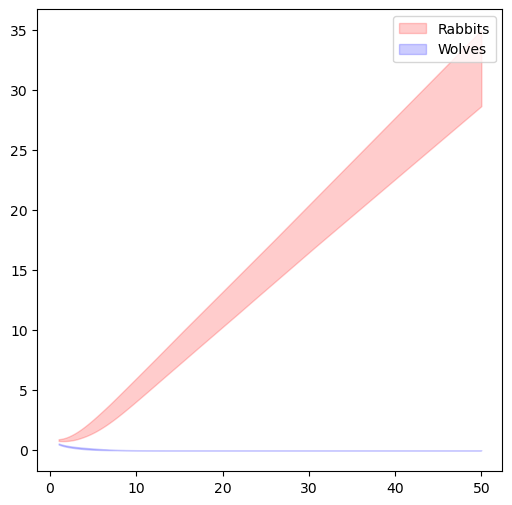

In [7]:
raw_lotka_volterra = MiraRegNetODESystem.from_askenet(filename)
uncertain_lotka_volterra = setup_petri_model(
    raw_lotka_volterra, start_time=0.0, start_state=dict(
        Rabbits=1.0, Wolves=1.0))
prior_samples = sample_petri(uncertain_lotka_volterra, tspan, 50)
plot_trajectories(prior_samples, tspan)

## Calibrate uncertain Lotka Volterra

We make one observation per day. Because we simulate 500 data points over 50 days, we need to sample every 10th timepoint.

### Sample trajectory

In [13]:
observed_lotka_volterra = reparameterize(
    uncertain_lotka_volterra,
    dict(alpha=0.67,beta=1.33,gamma=1.0, delta = 1.0))
observed_trajectory = sample_petri(deterministic_lotka_volterra, tspan, 1)
data =[(i, dict(Rabbits=observed_trajectory['Rabbits_sol'][0][i*10]))
            for i in range(1,50)]
plot_trajectories(observed_trajectory, tspan, data)

ERROR:root:
                ###############################

                There was an exception in pyciemss
                
                Error occured in function: sample_petri

                Function docs : 
    Sample `num_samples` trajectories from the prior or posterior distribution over ODE models.
    

                ################################
            
Traceback (most recent call last):
  File "/Users/altu809/Projects/pyciemss/src/pyciemss/custom_decorators.py", line 9, in wrapped
    result = function(*args, **kwargs)
  File "/Users/altu809/Projects/pyciemss/src/pyciemss/PetriNetODE/interfaces.py", line 900, in sample_petri
    assert len(petri._static_events) > 0, "No events initialized."
AssertionError: No events initialized.


AssertionError: No events initialized.

trajectory = sample_petri(deterministic_lotka_volterra, tspan, 1)
data =[(i, dict(Rabbits=trajectory['Rabbits_sol'][0][i*10]))
            for i in range(1,50)]
fitted_parameters = calibrate_petri(uncertain_lotka_volterra, data = data )
posterior_samples = sample_petri(uncertain_lotka_volterra, 
                                 timepoints=tspan, num_samples=50, 
                           inferred_parameters=fitted_parameters)
plot_trajectories(dict(
        Rabbits_prior_sol= prior_samples['Rabbits_sol'], 
        Wolves_prior_sol= prior_samples['Wolves_sol'],
        Rabbits_posterior_sol= posterior_samples['Rabbits_sol'],
        Wolves_posterior_sol= posterior_samples['Wolves_sol'],
        Rabbits_data_sol=trajectory['Rabbits_sol'],
    ),    
    tspan, data=data)

In [ ]:
import numpy as np
var = 'Rabbits_sol'
x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
x
y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
y

### Sample trajectories from interventional distribution
At $t=25$ we intervene on the prior parameters to set $\alpha=1.5$.

In [ ]:
intervened_lotka_volterra = intervene_petri_model(
    uncertain_lotka_volterra, [(25, 'alpha', 1.5)])
intervened_samples = sample_petri(
    intervened_lotka_volterra, timepoints=tspan, num_samples = 50)
ax = plot_trajectories(intervened_samples, tspan, data)
ax = plot_intervention_line(25, ax=ax)
ax.legend()

### Sample trajectories from counterfactual distribution
At $t=25$ here we intervene on the calibrated parameters to set $\alpha=1.5$

In [ ]:
observed_lotka_volterra = reparameterize(
    uncertain_lotka_volterra,
    dict(alpha=0.67,beta=1.33,gamma=1.0, delta = 1.0))
observed_trajectory = sample_petri(deterministic_lotka_volterra, tspan, 1)
data =[(i, dict(Rabbits=observed_trajectory['Rabbits_sol'][0][i*10]))
            for i in range(1,50)]
calibrated_parameters = calibrate_petri(
    uncertain_lotka_volterra, data = data)
counterfactual_samples = sample_petri(
    intervened_lotka_volterra, timepoints=tspan, num_samples = 50,
    inferred_parameters=calibrated_parameters)

In [ ]:
ax= plot_trajectories(counterfactual_samples, tspan, data=data)
ax = plot_intervention_line(25, ax)
ax.legend()

In [ ]:
data

In [ ]:
d_keys = [list(x[1].keys())[0] for x in data] if data else [] # get affected variables
d_keys

In [ ]:
observed_trajectory